# HW CI-4  Clustering Algorithms
### Computational Intelligence - STRATEGOS UNIGE
#### Name (s) MICHELE ARDUINI, ALI TAKAFI
#### Date 07/04/2022

# Assignment: Develop Hard and Fuzzy Clustering Algorithms from scratch
We will implement some clustering algorithms from scratch and we will test on two data sets constituted by some 2-dimensional distributions of points.

Then we will apply our algorithms to a real-word data set.


### TODO:
1. Generate data sets DS1 (non overlapping blobs), DS2 (overlapping blobs) and load DS3 from the file iris.csv.
2. Implement K-Means, Fuzzy C- Means and Graded Possibilistic C-Means.
3. Implement  WTA and the $\alpha - cut$ defuzzifiers of fuzzy partitions.
4. Implement RAND and Jaccard Indeces for hard partition comparison
5. Apply K-Means, Fuzzy C-Means and Graded Possibilistic C-Means to the 3 data sets using a multi-start approach; search for 2, 3, and 4 clusters.
6.  Defuzzify the soft partitions of  Fuzzy C- Means and Graded Possibilistic C-Means using the WTA (Winner-Takes-All) criterion.
7. Visualize the results on the scatter plot, highlighting the centroids and using a different color for each cluster.
8.  Measure the *accuracy* of the hard partitions by comparing them with the ground-truth constituted by the targets of the data sets. For the comparison use RAND and Jaccard indeces. 

For the Graded Possibilistic C-Means use a possibilistic degree $\beta=0.8$ and a value of $\eta$ (identical for each cluster) comparable with the *standard_dev*$^2$ for data sets DS1 and DS2. For DS3 (Iris data set)  $\eta$ must be selected by checking the value of the accuracy (model selection - grid search).


### Optional part A: Consensus Matrix
1. Implement the Consensus Matrix technique for partition ensembling. 
2. For each data set, take the 9 best hard partitions (3 clusters) obtained for data set DS2 in Part A and construct an ensemble using the tecnique of the consensus matrix. 
3. Visualize the results on the scatter plot, highlighting the centroids and using a different color for each cluster.
4. Measure the *accuracy* of the  partition induced by  the consensus matrix  by comparing it with the ground-truth constituted by the targets of the data sets. For the comparison use RAND index. Find the best value for the threshold $\alpha$.

### Optional part B: Study of the Graded Possibilistic C-Means algorithm

see below



## Import libraries

In [1]:
# add here the required imports
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from scipy.spatial import Voronoi, voronoi_plot_2d #for voronoi tessellation

## 1 Data sets generation

### Data set DS1: Separate blobs

 * number of points in the dataset  400
 * number of features in the dataset  2
 * number of clusters in the dataset 3   
 * standard deviation of points of a cluster 0.70 

In [2]:
# Dataset setup
number_of_points = 400   # number of points in the dataset
number_of_features = 2    # number of features in the dataset
number_of_clusters = 3    # number of clusters in the dataset
standard_dev = 0.70       # standard deviation of points of a cluster


features, target = make_blobs(n_samples = number_of_points, 
                  n_features = number_of_features,
                  centers = number_of_clusters,
                  cluster_std = standard_dev,
                  shuffle = True)

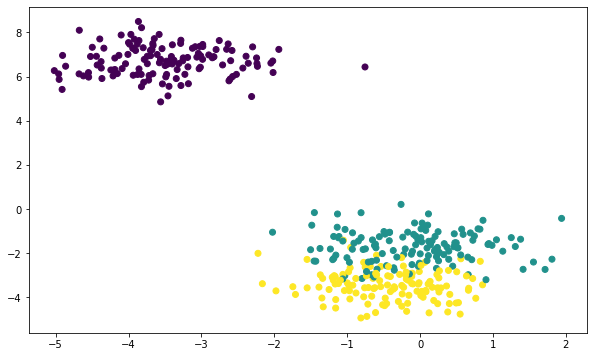

In [3]:
# Create a scatterplot of first two features
plt.figure(figsize=(10,6))
plt.scatter(features[:,0], features[:,1], c=target)

# View scatterplot
plt.show()

In [4]:
x_labels = ['Feature'+str(x) for x in range(features.shape[1])]
y_label = 'target'

feats = pd.DataFrame(features, columns=x_labels)
tgts = pd.Series(target, name=y_label)
dataset1 = pd.concat([feats,tgts],axis=1)
dataset1.head()

,Feature0,Feature1,target
0,1.252498,-1.292913,1
1,-0.750293,-2.451978,1
2,-0.113706,-3.049815,2
3,-4.952997,5.870640,0
4,-1.185055,-1.239864,1


### Data set DS2: Overlapping  blobs
 * number of points in the dataset  400
 * number of features in the dataset  2
 * number of clusters in the dataset 3   
 * standard deviation of points of a cluster 1.70 

In [5]:
# Dataset setup
number_of_points = 1000 # 400   # number of points in the dataset
number_of_features = 2    # number of features in the dataset
number_of_clusters = 3    # number of clusters in the dataset
standard_dev = 1.70       # standard deviation of points of a cluster


features, target = make_blobs(n_samples = number_of_points, 
                  n_features = number_of_features,
                  centers = number_of_clusters,
                  cluster_std = standard_dev,
                  shuffle = True)

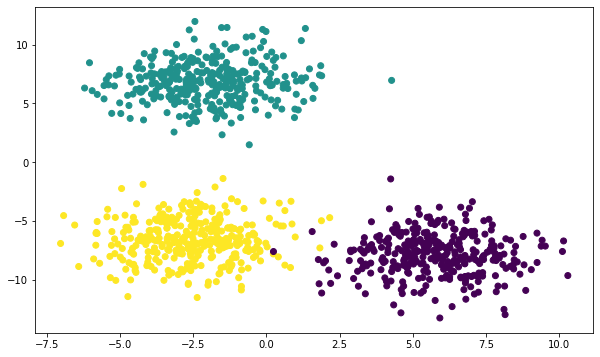

In [6]:
# Create a scatterplot of first two features
plt.figure(figsize=(10,6))
plt.scatter(features[:,0], features[:,1], c=target)

# View scatterplot
plt.show()

In [7]:
x_labels = ['Feature'+str(x) for x in range(features.shape[1])]
feats = pd.DataFrame(features, columns=x_labels)
tgts = pd.Series(target, name='target')
dataset2 = pd.concat([feats,tgts],axis=1)
dataset2.head()

,Feature0,Feature1,target
0,-1.647035,-4.753507,2
1,1.592160,5.430857,1
2,4.783674,-7.223704,0
3,4.821973,-9.377537,0
4,4.620610,-7.535530,0


### Data set DS3: Iris Data set 

Read the data set from the file *iris.csv* as done in *HW-CI-3-KNN.ipynb*


In [8]:
col_names = ['sl', 'sw', 'pl', 'pw', 'target']
x_labels = ['sl', 'sw', 'pl', 'pw']
y_labels = ['target']

feats = pd.read_csv('iris.csv', names=col_names, usecols=x_labels)
tgts = pd.read_csv('iris.csv', names=col_names, usecols=y_labels, squeeze=True)
dataset3 = pd.concat([feats,tgts],axis=1)

class_map = {v: c for c, v in enumerate(dataset3['target'].unique())}
dataset3['target'] = dataset3['target'].map(class_map)

iris = dataset3.iloc[:, 0:4]
iris_array = iris.to_numpy()

dataset3.head()

,sl,sw,pl,pw,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 2 Implentation of clustering algoritms 

### K-Means (aka Hard C-Means)
K-Means minimizes the functional 
 
 
 $$
  E(X) = \sum_{i=1}^{K}\sum_{{\bf x} \in \pi_i} \| {\bf x} - {\bf v}_i \|^2
=\sum_{ih} u_{ih}\| {\bf x}_{h} - {\bf v}_i \|^2,\; \;  \mbox{with}\; \; u_{ih}= \left \{ 
 \begin{array}{ll}    
          1 & if \; \boldsymbol{x}_{h} \in \pi_i \\
         0 & otherwise
        \end{array}\right. $$
        
 
 where $\bf x$ is a point of the data set, $n$ is the size of the data set, $K$ is the number of clusters,  ${\bf v}_i$ are the centroids, and
 $\pi_i$ is the subset of the data set belonging to cluster $i$. Note that $E(X)$ is proportional to the expectation of distortion.
 
In this implementation we will initialize the cluster centers by selecting at random  K  points from the data set, and  then we will iterate the re-evaluation of all $\pi_i$ and of ${\bf v}_i$, until a STOP CRITERION holds.
 
The STOP CRITERION can be:

1. *Stop when the variation of $E(X)$ in two subsequent cycles ($\Delta E$) is under an assigned threshold $\tau > 0$*.
2. *Stop when the maximum variation of the centroids ${\bf v}_i$  in two subsequent cycles ($\Delta {\bf v}$) is under an assigned threshold $\tau > 0$*.
3. *Stop after an assigned number $S$ of iterations*.

We suggest to use the following combined STOP CRITERION:  **Stop after an assigned numer $S$ of iterations** AND **Stop when the variation of $<E> =\frac{E(X)}{K \cdot n}$ in two subsequent cycles ($\Delta <E>$) is under an assigned threshold $\tau > 0$**.

In [9]:
class KMeans:

    def __init__(self, c, tau=0.001, max_iter=300, verbose=False):
        self.k = c # number of centroids
        self.tau = tau # stopping threshold
        self.max_iter = max_iter # maximum number of iterations in case of no convergence
        self.verbose = verbose # detailed printout
        self.cost = list() # service variable to store cost history
        self.centroids = None # centroids after fitting
        self.U = None # membership matrix (for K-Means U is hard, i.e. its element are 0/1)

        # other variables shared among the various functions
        self.n = 0 # holds the dataset size
        self.prev_error = np.inf # assign initial error as infinite
        self.iteration = None # interation number
        self.error =  None # private variable to hold error E(X)
        self.distances = None # private variable to hold distances
        self.prev_centroids = None
        self.x_map = None
               
    def get_centroids(self):
        return self.centroids
    
    def get_U(self):
        return self.U
    
    def get_cost_history(self):
        return self.cost
    
    def plot_cost_history(self, size_x = 15, size_y = 6, data=None, label=None):
        if data==None:
            data= self.cost
        if label==None:
            label = 'Cost History'
            
        # simply plot the cost history
        fig, ax = plt.subplots(figsize=(size_x,size_y))

        ax.plot(data, color='r', label=label)     # cost line
        ax.legend()
        plt.show()
        return ax

    def calc_cost(self):
        # reset distances for items for farther clusters
        # define the cluster index list for data items
        x_map = np.argmin(self.distances,axis=1)
        # define the membership matrix from cluster index list
        # u becomes 1 for items in given cluster and zero for the others
        u = np.zeros_like(self.distances)
        # set the distances other than minimal to zero
        u[np.arange(self.n),x_map] = 1
        dist = np.multiply(self.distances,u)
        if self.verbose: sys.stderr.write('dist: {}\n'.format(dist))
        # compute the error - <E> expectation of distortion
       
        self.error = np.sum(dist)/(self.k*self.n)
        #self.error = np.sum(dist)
       
        #delta_e = np.abs(self.prev_error - error)
        delta_e = self.prev_error - self.error
        #print ("error= ", error, " delta_error= ", delta_e)
        self.cost.append(self.error)
        self.prev_error = self.error
        return delta_e

    def predict(self,x):
        # checks the test samples and return the list of centroid indexes 
        # which each sample belongs to

        if self.verbose: sys.stderr.write('centroids: {}\n'.format(self.centroids))

        # compute distances from centroids
        for i in range(self.n):
            for j in range(self.k):
                #self.distances[i][j] = np.sqrt(np.sum((x[i]-self.centroids[j])**2))
                #self.distances[i][j] = np.sum((x[i]-self.centroids[j])**2)
                self.distances[i][j] = np.sum(np.dot(x[i]-self.centroids[j],x[i]-self.centroids[j]))
                # In the implementation of K-Means  we sort the distances of an instance from  
                # all centroids using the squared Euclidean distance, 
                # as the square root is a monotone function. 
           
                
        #print (self.distances)
        # assign the points of the data sets to the k clusters (nearest centroid)
        self.x_map = np.argmin(self.distances,axis=1) # for each data point i -row-, 
                                                      # it returns the index of the minimum 
                                                      # distance between i and a cluster j, i.e
                                                      # the index j of the closest cluster to i 
        return self.x_map

    def get_centroids_distance(self):
        clu_dist = 0
        for c, pc in zip(self.centroids,self.prev_centroids): clu_dist += np.sqrt(np.dot(c-pc,c-pc))
        return clu_dist
    
    def fit (self, x):
        # performs kmeans clustering on training samples and assign centroids
        self.n = x.shape[0]  # number of training items
        c = x.shape[1]  # number of features 

        # initialize the K centroids by selecting at random  K  points from the data_set
        idx = np.random.randint(self.n,size=self.k)
        self.centroids = x[idx].copy()
        self.prev_centroids = self.centroids.copy()

        # initialize the membership matrix with n rows and k columns
        self.U = np.zeros((self.n,self.k), dtype=int)
        # create a distance matrix with the same shape as the membership one
        self.distances = np.zeros_like(self.U,dtype=float)

        # iterate while DELTA E > tau (STOP CRITERION #1) or max_iter not reached
        loop = True
        self.iteration = 0
        while (loop):
            # match training data to the current centroids and update their
            # membership index list
            self.x_map = self.predict(x)
            if self.verbose: sys.stderr.write('x_map: {}\n'.format(self.x_map))

            #   calculate the new k centroids
            for i in range(self.k):
                # perform the average only if the centroid has assigned elements
                # otherwise NaN is assigned and the algorithm has errors
                if (self.x_map == i).any(): 
                    self.centroids[i] = np.average(x[self.x_map == i], axis=0)

            delta_cost = self.calc_cost()
            self.iteration +=1 
            # break the loop if the stopping conditions are met
            clu_dist = self.get_centroids_distance()
            self.prev_centroids = self.centroids.copy()
            if self.verbose:
                  print(self.iteration, "error= ", self.error, " delta_error= ", delta_cost, "tau = ", self.tau)
            loop = (abs(delta_cost) > self.tau) and (self.iteration < self.max_iter)

            #loop = (delta_cost > self.tau) and (clu_dist > self.tau) and (self.iteration < self.max_iter)

        # set the membership matrix for the final configuration 
        self.U[np.arange(self.n),self.x_map] = 1

        return self

### Fuzzy C-Means

Fuzzy C-Means minimizes the functional

  $$J(U, V) = \sum_{h=1}^{n}\sum_{i=1}^{c} \left( u_{ih} \right)^m \| \mathbf{x}_h - \mathbf{v}_i \|^2 \;, \qquad \forall h=1, \ldots, n\qquad \forall i=1, \ldots, c$$


  
 with the  probabilistic constraint

  $$\sum_{i=1}^{c} u_{ih} = 1 $$
  
  where ${\bf x}_h$ are the point of the data set, $c$ is the number of clusters,  ${\bf v}_i$ are the centroids, and
  $u_{ih}$ are the membrships of data points to clusters.
 
 
In this implementation we will initialize the cluster centers ${\bf v}_i$ by selecting at random  $c$  points from the data set, and  then we will iterate the re-evaluation of all $u_{ih}$ and of $\bf {v}_i$,

 $$ u_{ih} = \frac{1}{\sum_{j=1}^{c}
    \left( \frac{\| \mathbf{x}_h - \mathbf{v}_i \|}{\|\mathbf{x}_h - \mathbf{v}_j\|} \right)^{\frac{2}{m-1}} }$$

 
$$ \mathbf{v}_i = \frac{\sum_{h=1}^{n} \left( u_{ih} \right)^m \mathbf{x}_h}
         {\sum_{h=1}^{n} \left( u_{ih} \right)^m}$$

 
until a STOP CRITERION holds.
 
The STOP CRITERION can be either: 
1. *Stop when the variation of $J(U, V)$ in two subseguent cycles ($\Delta J$) is under an assigned threshold $\tau > 0$*.
2. *Stop when the variation of $$ E(X) =\sum_{ih} u_{ih}\| {\bf x}_{h} - {\bf v}_i \|^2 $$ 
in two subseguent cycles ($\Delta E$) is under an assigned threshold $\tau >0 $*.
3. *Stop when the maximum variation of the centroids ${\bf v}_i$ in  two subseguent cycles ($\Delta {\bf v}$) is under an assigned threshold $\tau \ge 0$*.
4. *Stop when the maximum variation of the memberships  $u_{ih}$ in two subseguent cycles ($\Delta u$) is under an assigned threshold $\tau \ge 0$*.
5. Stop after an assigned number $S$ of iterations.



We suggest to use the following combined STOP CRITERION:  **Stop after an assigned number $S$ of iterations** AND **Stop when the variation of $<E> =\frac{E(X)}{c\cdot n}$ in two subseguent cycles ($\Delta <E>$) is under an assigned threshold $\tau > 0$**.


In [10]:
# Fill this cell with the skeleton code provided for KMeans and apply proper 
# modifications to implement the FuzzyCMeans algorithm.

# the constructor must have the following arguments:
# c, as the number of centroids
# m, as the fuzzyness parameter (usually m=2)
# tau, as the stopping criterion
# max_iterations

# initialize the c centroids by selecting at random c points from the data_set
# iterate until DELTA E < tau (STOP CRITERION #2)
#   assign the points of the data sets to the c clusters (nearest centroid)
#   calculate the new c centroids

# record also delta_e history in addition to cost
# provide a function to retrieve the membership matrix U
# (it could be an extra return parameter from predict function)

class CMeans:

    def __init__(self, g, c, m=2, tau=0.001, max_iter=300):
        self.c = c # number of centroids
        self.m = m # fuzziness parameter
        self.tau = tau # stopping threshold
        self.max_iter = max_iter # maximum number of iterations in case of no convergence
        self.eta = None # width of clusters used in GPCM
        self.g = g # constant to estimate eta used in GPCM
        self.cost = list() # service variable to store cost history
        self.centroids = None # centroids after fitting
        self.U = None # membership matrix

        # other variables shared among the various functions
        self.n = 0 # holds the dataset size
        self.prev_error = np.inf # assign initial error as infinite
        self.iteration = None # interation number
        self.error =  None # private variable to hold error E(X)
        self.distances = None # private variable to hold distances
        self.dist = None # weighted distances
        self.prev_centroids = None
        self.x_map = None # an array with the index of cluster assigned to points based on distances
               
    def get_centroids(self):
        return self.centroids
    
    def get_U(self):
        return self.U
    
    def get_cost_history(self):
        return self.cost
    
    def plot_cost_history(self, size_x = 15, size_y = 6, data=None, label=None):
        if data==None:
            data= self.cost
        if label==None:
            label = 'Cost History'
            
        fig, ax = plt.subplots(figsize=(size_x,size_y))

        ax.plot(data, color='r', label=label)     # cost line
        ax.legend()
        plt.show()
        return ax

    def get_eta(self):

        self.eta = (self.g*np.nansum(np.multiply(self.U, self.distances), 0)/np.nansum(self.U, 0))

        return self.eta

    def calc_cost(self, x):
        
        # define the membership matrix
        u = np.zeros((self.n, self.c))
        membership = np.zeros((1, self.c))
        for i in range(self.n):
            for j in range(self.c):
                for h in range(self.c):
                    set_error = np.seterr(divide='ignore', invalid='ignore')
                    membership[0][h] = (np.sum(np.dot(x[i]-self.centroids[j],x[i]-self.centroids[j]))/np.sum(np.dot(x[i]-self.centroids[h],x[i]-self.centroids[h])))**(1/self.m-1)
                u[i][j] = (np.sum(membership, axis=1))**(-1) # membership of (data)point i to cluster j 
                self.distances[i][j] = np.sum(np.dot(x[i]-self.centroids[j],x[i]-self.centroids[j])) # distance of (data)point i from centroid j 
        self.U = u
        
        # compute the 'weighted' distances
        self.dist = np.multiply(self.distances, u**self.m)

        # compute the error (cost) associated with current set of centroids
        self.error = np.sum(self.dist)/(self.c*self.n)
        #self.error = np.sum(dist)

        # compute the difference of error associated with current and previous set centroids
        #delta_e = np.abs(self.prev_error - error)
        delta_e = self.prev_error - self.error
        self.cost.append(self.error)
        self.prev_error = self.error
        return delta_e

    def predict(self,x):
        # checks the test samples and return the list of centroid indexes 
        # which each sample belongs to

        

        # compute distances from centroids
        for i in range(self.n):
            for j in range(self.c):
                #self.distances[i][j] = np.sqrt(np.sum((x[i]-self.centroids[j])**2))
                #self.distances[i][j] = np.sum((x[i]-self.centroids[j])**2)
                self.distances[i][j] = np.sum(np.dot(x[i]-self.centroids[j],x[i]-self.centroids[j]))
                # In the implementation of K-Means  we sort the distances of an instance from  
                # all centroids using the squared Euclidean distance, 
                # as the square root is a monotone function. 
           
                
        #print (self.distances)
        # assign the points of the data sets to the k clusters (nearest centroid)
        self.x_map = np.argmin(self.distances,axis=1) # for each data point i -row-, 
                                                      # it returns the index of the minimum 
                                                      # distance between i and a cluster j, i.e
                                                      # the index j of the closest cluster to i 
        return self.x_map

    def get_centroids_distance(self):
        clu_dist = 0
        for c, pc in zip(self.centroids,self.prev_centroids): clu_dist += np.sqrt(np.dot(c-pc,c-pc))
        return clu_dist
    
    def fit (self, x):
        # performs C-means clustering on training samples and assigns centroids
        
        self.n = x.shape[0]  # number of training items
        self.f = x.shape[1]  # number of features 

        # initialize the c centroids by selecting at random  c  points from the dataset
        idx = np.random.randint(self.n,size=self.c)
        self.centroids = x[idx].copy()
        self.prev_centroids = self.centroids.copy()

        # initialize the membership matrix with n rows and c columns
        self.U = np.zeros((self.n, self.c))

        # create a distance matrix with the same shape as the membership one
        self.distances = np.zeros_like(self.U,dtype=float)

        # iterate while delta_e > tau or/and max_iter not reached
        loop = True
        self.iteration = 0
        while (loop):

            self.x_map = self.predict(x)

            # calculate the new k centroids
            for j in range(self.c):
                # perform a weighted average only if the centroid has assigned elements
                # otherwise NaN is assigned and the algorithm has errors
                if (self.U[:, j]).any(): #checks if at lest one datapoint was assigned to cluster (centroid) j 
                    v = np.zeros((1, self.f))
                    v_prev = np.zeros((1, self.f))
                    for i in range(self.n):
                        v_prev = v
                        v = np.add(v_prev, self.U[i, j]*x[i])
                    self.centroids[j] = v/np.sum(self.U[:, j])

            # break the loop if the stopping conditions are met
            delta_cost = self.calc_cost(x)
            self.iteration +=1 
            clu_dist = self.get_centroids_distance()
            self.prev_centroids = self.centroids.copy()
            loop = (abs(delta_cost) > self.tau) and (self.iteration < self.max_iter)
            #loop = (delta_cost > self.tau) and (clu_dist > self.tau) and (self.iteration < self.max_iter)

        return self

### Graded Possibilistic C-Means (GPCM)

Graded Possibilistic C-Means (GPCM)


 
 In this implementation we will initialize the cluster centers ${\bf v}_i$ by selecting at random  $c$  points from the data set, and  then we will iterate the re-evaluation of all $u_{ih}$ and of $\bf {v}_i$,
 
$$ u_{hi} = \frac{\Omega_{hi}}{Z_h} \,,\quad \Omega_{hi} = e^{-\|\mathbf{x}_h - \mathbf{v}_i\|^2/\eta_i} \,,\quad 
Z_h =  \left(\sum_{i=1}^c \Omega_{hi}\right)^\beta
\,,\quad\beta\in[0,1]$$



 
 
$$ \mathbf{v}_i = \frac{\sum_{h=1}^{n} u_{ih} \mathbf{x}_h}
         {\sum_{h=1}^{n} u_{ih} 
        }$$

 
 until until a STOP CRITERION holds.
 

 
 $\beta \in [0,1]$ is the *possibilistic degree* and establishes the grade between possibilistic and probabilistic clustering.
 
 $\eta_j > 0 $ is the spread of clusters. It can be set a-priori or estimated by using
 
 $$
  \eta_i = \gamma \frac{\sum_{h=1}^n u_{ih}\ \| \mathbf{x}_h - \mathbf{v}_i \|^2}
      {\sum_{i=1}^n u_{ih}}$$

after an initialization with a Fuzzy C-Means algorithm ($\gamma >0$, try $\gamma\approx 1$).


The STOP CRITERION for the GPCM can be either: 
1. *Stop when the variation of  $$ E(X) =\sum_{ih} u_{ih}\| {\bf x}_{h} - {\bf v}_i \|^2. $$ 
 in two subseguent cycles ($\Delta E$) is under an assigned threshold $\tau >0 $*.
2. *Stop when the maximum variation of the centroids ${\bf v}_i$ in two subseguent cycles ($\Delta {\bf v}$) is under an assigned threshold $\tau \ge 0$*.
3. *Stop when the maximum variation of the memberships  $u_{ih}$ in two subseguent cycles ($\Delta u$) is under an assigned threshold $\tau \ge 0$*.
4. Stop after an assigned number $S$ of iterations.

We suggest to use the following combined STOP CRITERION:  **Stop after an assigned number $S$ of iterations** AND **Stop when the variation of $<E> =\frac{E(X)}{c \cdot n}$ in two subseguent cycles ($\Delta <E>$) is under an assigned threshold $\tau > 0$**.


In [11]:
# Fill this cell with the skeleton code provided for KMeans and apply proper 
# modifications to implement the GPCMeans algorithm.

# the constructor must have the following arguments:
# c, as the number of centroids
# beta, as the possibilistic degree
# tau, as the stopping criterion
# eta (one for each cluster), as the estimated spread of clusters
# max_iterations

# initialize the c centroids by selecting at random c points from the data_set
# iterate until DELTA E < tau (STOP CRITERION #1)
#   assign the points of the data sets to the c clusters (nearest centroid)
#   calculate the new c centroids

# record also delta_e history in addition to cost
# provide a function to retrieve the membership matrix U
# (it could be an extra return parameter from predict function)


class GPCM:

    def __init__(self, gamma, c, m=2, tau=0.001, max_iter=300, beta=0.5):
        self.c = c # number of centroids
        self.m = m # fuzziness parameter
        self.tau = tau # stopping threshold
        self.max_iter = max_iter # maximum number of iterations in case of no convergence
        self.eta = None # width of clusters, calculated after an initialization with fuzzy C-Means
        self.gamma = gamma # constant to calculate eta 
        self.beta = beta # constant to calculate zeta
        self.cost = list() # service variable to store cost history
        self.centroids = None # centroids after fitting
        self.U = None # membership matrix

        # other variables shared among the various functions
        self.n = 0 # holds the dataset size
        self.prev_error = np.inf # assign initial error as infinite
        self.iteration = None # interation number
        self.error =  None # private variable to hold error E(X)
        self.distances = None # private variable to hold distances
        self.dist = None # weighted distances
        self.prev_centroids = None
        self.x_map = None # an array with the index of cluster assigned to points based on distances
               
    def get_centroids(self):
        return self.centroids
    
    def get_U(self):
        return self.U
    
    def get_cost_history(self):
        return self.cost
    
    def plot_cost_history(self, size_x = 15, size_y = 6, data=None, label=None):
        if data==None:
            data= self.cost
        if label==None:
            label = 'Cost History'
            
        fig, ax = plt.subplots(figsize=(size_x,size_y))

        ax.plot(data, color='r', label=label)     # cost line
        ax.legend()
        plt.show()
        return ax

    def calc_cost(self, x):
        
        # define the membership matrix
        u = np.zeros((self.n, self.c))

        # define omega matrix
        omega = np.zeros((self.n, self.c))

        # define zeta matrix
        zeta = np.zeros((self.n, 1))

        for i in range(self.n):
            for j in range(self.c):
                set_error = np.seterr(divide='ignore', invalid='ignore')
                omega[i][j] = np.exp(-np.sum(np.dot(x[i]-self.centroids[j], x[i]-self.centroids[j])**(1/self.eta[j])))
                zeta[i][0] = (np.sum(omega[i, :]))**self.beta
                u[i][j] = omega[i][j]/zeta[i][0] # membership of (data)point i to cluster j
                self.distances[i][j] = np.sum(np.dot(x[i]-self.centroids[j],x[i]-self.centroids[j])) # distance of (data)point i from centroid j 
        self.U = u
        
        # compute the 'weighted' distances
        self.dist = np.multiply(self.distances, u**self.m)

        # compute the error (cost) associated with current set of centroids
        self.error = np.sum(self.dist)/(self.c*self.n)
        #self.error = np.sum(dist)

        # compute the difference of error associated with current and previous set centroids
        #delta_e = np.abs(self.prev_error - error)
        delta_e = self.prev_error - self.error
        self.cost.append(self.error)
        self.prev_error = self.error
        return delta_e
    
    def predict(self,x):
        # checks the test samples and return the list of centroid indexes 
        # which each sample belongs to

        

        # compute distances from centroids
        for i in range(self.n):
            for j in range(self.c):
                #self.distances[i][j] = np.sqrt(np.sum((x[i]-self.centroids[j])**2))
                #self.distances[i][j] = np.sum((x[i]-self.centroids[j])**2)
                self.distances[i][j] = np.sum(np.dot(x[i]-self.centroids[j],x[i]-self.centroids[j]))
                # In the implementation of K-Means  we sort the distances of an instance from  
                # all centroids using the squared Euclidean distance, 
                # as the square root is a monotone function. 
           
                
        #print (self.distances)
        # assign the points of the data sets to the k clusters (nearest centroid)
        self.x_map = np.argmin(self.distances,axis=1) # for each data point i -row-, 
                                                      # it returns the index of the minimum 
                                                      # distance between i and a cluster j, i.e
                                                      # the index j of the closest cluster to i 
        return self.x_map

    def get_centroids_distance(self):
        clu_dist = 0
        for c, pc in zip(self.centroids,self.prev_centroids): clu_dist += np.sqrt(np.dot(c-pc,c-pc))
        return clu_dist
    
    def fit (self, x):
        # performs Greded Possibilistic C-means (GPCM) clustering on training samples and assigns centroids
        
        self.n = x.shape[0]  # number of training items
        self.f = x.shape[1]  # number of features 

        self.eta = CMeans(g=self.gamma, c=self.c).fit(x).get_eta()

        # initialize the c centroids by selecting at random  c  points from the dataset
        idx = np.random.randint(self.n, size=self.c)
        self.centroids = x[idx].copy()
        self.prev_centroids = self.centroids.copy()

        # initialize the membership matrix with n rows and c columns
        self.U = np.zeros((self.n, self.c))

        # create a distance matrix with the same shape as the membership one
        self.distances = np.zeros_like(self.U, dtype=float)

        # iterate while delta_e > tau or/and max_iter not reached
        loop = True
        self.iteration = 0
        while (loop):
            
            self.x_map = self.predict(x)

            # calculate the new k centroids
            for j in range(self.c):
                # perform a weighted average only if the centroid has assigned elements
                # otherwise NaN is assigned and the algorithm has errors
                if (self.U[:, j]).any(): #checks if at lest one datapoint was assigned to cluster (centroid) j 
                    v = np.zeros((1, self.f))
                    v_prev = np.zeros((1, self.f))
                    for i in range(self.n):
                        v_prev = v
                        v = np.add(v_prev, self.U[i, j]*x[i])
                    self.centroids[j] = v/np.sum(self.U[:, j])

            # break the loop if the stopping conditions are met
            delta_cost = self.calc_cost(x)
            self.iteration +=1 
            clu_dist = self.get_centroids_distance()
            self.prev_centroids = self.centroids.copy()
            loop = (abs(delta_cost) > self.tau) and (self.iteration < self.max_iter)
            #loop = (delta_cost > self.tau) and (clu_dist > self.tau) and (self.iteration < self.max_iter)

        return self

## 3 Defuzzification of fuzzy partitions

The output of a fuzzy clustering algorithm is a soft (fuzzy) partition of the data set defined by the partition matrix $U$.

To transform a soft partition of data set in a hard partition, we must apply the  winner take all (WTA) or  the  $\alpha$-cut rules:
* the winner take all (WTA) rule   for each data point finds the clustering with higher membership value and change this value to $1$ and set the memberships to the other clusters to $0$;
* the $\alpha$-cut rule compares the membership of  each data point to a cluster and if it is larger than  $\alpha$ change it to $1$, otherwise set it to $0$.


In [12]:
def WTA(U): # Winner Take All rule. U is the membership matrix
    hard_U = np.empty_like(U)
    for i in range(U.shape[0]):
        hard_U[i] = np.where(U[i, :]==np.amax(U[i, :]), 1, 0)

    return hard_U

In [13]:
def alpha_cut(U, alpha): # alpha-cut rule. U is the membership matrix, 
                         # alpha is the threshold
    hard_U = np.empty_like(U)
    for i in range(U.shape[0]):
        hard_U[i] = np.where(U[i, :]>alpha, 1, 0)
    
    return hard_U

## 4 Partition similarity indeces

## Rand Index

Given two hard partitions $A$ and  $B$ of a data set $Z$, we call

* $n_{11}$ number of pairs of data points in $Z$ both in the same cluster in A and in the same cluster in B
* $n_{00}$ number of pairs of data points in $Z$ both in different clusters in A and in different clusters in B
* $n_{01}$ number of pairs of data points in $Z$ both in different clusters in A and in the same cluster in B
* $n_{10}$ number of pairs of data points in $Z$ both in the same cluster in A and in different clusters in B

the Rand index is defined as
$$ r(A,B)=\frac{n_{00}+n_{11} }{n_{00}+n_{11}+n_{01}+n_{10}}$$

NOTE: If A and B are identical $r(A,B)= 1 $.


In [14]:
class rand_partition_similarity:

    def __init__(self):

        return None 

    def point_cluster(self, M):
        cluster_map = np.zeros(M.shape[0])
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                if M[i, j] == 1:
                    cluster_map[i] = j
        return cluster_map


    def rand_index(self, A, B):
        n = min(A.shape[0], B.shape[0])
        count = np.zeros((n, 4))
        similarity_matrix = np.zeros((2,2))

        for i in range(n):
            for j in range(n):
                if not i == j:
                    if self.point_cluster(A)[i] != self.point_cluster(A)[j] and self.point_cluster(B)[i] != self.point_cluster(B)[j]: # different clusters in A and different clusters in B
                        count[i, 0] += 1
                    if self.point_cluster(A)[i] != self.point_cluster(A)[j] and self.point_cluster(B)[i] == self.point_cluster(B)[j]: # different clusters in A and same clusters in B
                        count[i, 1] += 1
                    if self.point_cluster(A)[i] == self.point_cluster(A)[j] and self.point_cluster(B)[i] != self.point_cluster(B)[j]: # same clusters in A and different clusters in B
                        count[i, 2] += 1
                    if self.point_cluster(A)[i] == self.point_cluster(A)[j] and self.point_cluster(B)[i] == self.point_cluster(B)[j]: # different clusters in A and different clusters in B
                        count[i, 3] += 1
                
        similarity_matrix = [[np.sum(count[:, 0]), np.sum(count[:, 1])], [np.sum(count[:, 2]), np.sum(count[:, 3])]] # the pairs xy and yx are considered different, we should 
                                                                                                                     # divide the elements similarity_matrix by 2 but for the 
                                                                                                                     # calculation of rand index it doesn't make a difference
        r = (similarity_matrix[0][0]+similarity_matrix[1][1])/(similarity_matrix[0][0]+similarity_matrix[1][1]+similarity_matrix[0][1]+similarity_matrix[1][0])

        return r

## Jaccard Index

Given the same definitions as for the Rand Index, the Jaccad Index is defined as:

$$ J(A,B) =\frac{n_{11}}{n_{11}+n_{01}+n_{10}}$$

In [15]:
class jaccard_partition_similarity:

    def __init__(self):
        return None 

    def point_cluster(self, M):
        cluster_map = np.zeros(M.shape[0])
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                if M[i, j] == 1:
                    cluster_map[i] = j
        return cluster_map


    def jaccard_index(self, A, B):
        n = min(A.shape[0], B.shape[0])
        count = np.zeros((n, 4))
        similarity_matrix = np.zeros((2,2))

        for i in range(n):
            for j in range(n):
                if not i == j:
                    if self.point_cluster(A)[i] != self.point_cluster(A)[j] and self.point_cluster(B)[i] != self.point_cluster(B)[j]: # different clusters in A and different clusters in B
                        count[i, 0] += 1
                    if self.point_cluster(A)[i] != self.point_cluster(A)[j] and self.point_cluster(B)[i] == self.point_cluster(B)[j]: # different clusters in A and same clusters in B
                        count[i, 1] += 1
                    if self.point_cluster(A)[i] == self.point_cluster(A)[j] and self.point_cluster(B)[i] != self.point_cluster(B)[j]: # same clusters in A and different clusters in B
                        count[i, 2] += 1
                    if self.point_cluster(A)[i] == self.point_cluster(A)[j] and self.point_cluster(B)[i] == self.point_cluster(B)[j]: # different clusters in A and different clusters in B
                        count[i, 3] += 1
                
        similarity_matrix = [[np.sum(count[:, 0]), np.sum(count[:, 1])], [np.sum(count[:, 2]), np.sum(count[:, 3])]] # the pairs xy and yx are considered different, we should 
                                                                                                                     # divide the elements similarity_matrix by 2 but for the 
                                                                                                                     # calculation of rand index it doesn't make a difference
        J = similarity_matrix[1][1]/(similarity_matrix[1][1]+similarity_matrix[0][1]+similarity_matrix[1][0])

        return J

## Clustering Accuracy
Accuracy of a clustering algo can be evaluated as similarity of the obtained partition to a
known labeling of the data.

Rand and Jaccard indeces can be used to evaluate clustering accuracy.


## 5, 6, 7, 8 Experiments

Note: Depending on the initialization, a clustering algorithm could trap in alocal minimum. **Multi-start euristics** consists in multiple runs of the algorithm with random inizializations and in the selection of the best one, on the basis ,e.g., of the minimum evaluation of $<E>$ after training. 

### 5, 7, 8 - Experiments with K-Means


In [16]:
def multi_start_KMeans(x, c, tau=.0001, num_iter=10):
    # constants assignement
    precision = 4
    E = np.inf

    runs = num_iter  # number of re-starts
    clusters=c
    tau_val=tau
    
    t_before = time.time()
    
    for i in range(runs):
        km = KMeans(clusters, tau=tau_val, verbose=False)
        km.fit(x)
        EE= km.error
        Niter= km.iteration
        #print("run = {} - <E> = {:.{}f} ".format(i, EE, precision))
        print("run = {} - iterations = {} - <E> = {:.{}f} ".format(i, Niter-1, EE, precision))
        
        if EE < E:
            # store the best instance of trained model
            kmi = km
            E=EE
            best_run=i

    print ('\n best run = {}\n <E> = {:.{}f}'.format(best_run, E, precision))
    
    t_after = time.time()
    
    ## Compute training time
    t_training = t_after - t_before
    
    print(" Time for multi-start training (seconds): {:.{}f}\n runs = {}\n".format(t_training, precision, runs))

    return kmi, E, best_run

In [17]:
def plot_clustered_data(x,y,c,preds):  # we plot the first two features, sepal length and sepal width 
    size_x = 16
    size_y = 6

    vor = Voronoi(c)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(size_x,size_y))
    ax1.scatter(x[:,0], x[:,1], c=y, alpha=0.5)
    ax1.set_title('Original Data')
    #ax1.legend()

    ax2.scatter(x[:,0], x[:,1], c=preds, alpha=0.5, label='Predictions')
    ax2.scatter(c[:,0], c[:,1], marker='P', c='red', label='Centroids')
    ax2.set_title('Clustered Data')
    ax2.legend()

    voronoi_plot_2d(vor, ax2, show_points=False, line_width=1, show_vertices=False)
    ax2.set_xlim(min(x[:,0])-1,max(x[:,0])+1)
    ax2.set_ylim(min(x[:,1])-1,max(x[:,1])+1)

    plt.show()

In [18]:
def visual_KMeans(dataset):

    x_labels = dataset.columns.values.tolist()
    x_labels.remove('target')
    y_label = 'target'

    x = np.array(dataset[x_labels].copy())
    y = np.array(dataset[y_label].copy())
    km, E, best_run = multi_start_KMeans(x, c=3, num_iter=10)
    c = km.get_centroids()[:, 0:2] # we plot the first two features, sepal length and sepal width
    U = km.get_U()
    hist = km.get_cost_history()
    p = km.predict(x)
    #print(U,p)
    plot_clustered_data(x,y,c,p)
    km.plot_cost_history(data=hist, label="Learning curve")
    
    return

run = 0 - iterations = 5 - <E> = 0.1754 
run = 1 - iterations = 5 - <E> = 0.1754 
run = 2 - iterations = 8 - <E> = 0.1754 
run = 3 - iterations = 8 - <E> = 0.1754 
run = 4 - iterations = 5 - <E> = 0.1754 
run = 5 - iterations = 6 - <E> = 0.1754 
run = 6 - iterations = 6 - <E> = 0.1754 
run = 7 - iterations = 4 - <E> = 0.1754 
run = 8 - iterations = 5 - <E> = 0.3188 
run = 9 - iterations = 6 - <E> = 0.1754 

 best run = 1
 <E> = 0.1754
 Time for multi-start training (seconds): 0.2001
 runs = 10



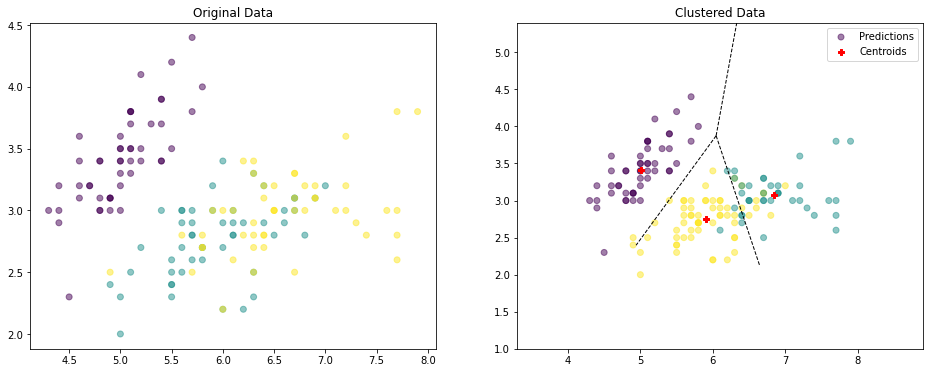

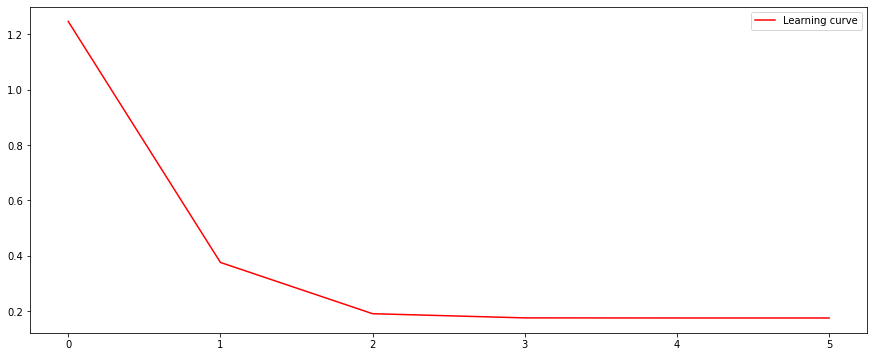

In [19]:
visual_KMeans(dataset3)

### 5, 6, 7, 8 -  Experiments with Fuzzy C-Means


In [20]:
def multi_start_CMeans(x, g, c, tau=.0001, num_iter=10):
    # constants assignement
    precision = 4
    E = np.inf

    runs = num_iter  # number of re-starts
    clusters = c
    tau_val=tau
    
    t_before = time.time()
    
    for i in range(runs):
        km = CMeans(g, clusters, tau=tau_val)
        km.fit(x)
        EE= km.error
        Niter= km.iteration
        #print("run = {} - <E> = {:.{}f} ".format(i, EE, precision))
        print("run = {} - iterations = {} - <E> = {:.{}f} ".format(i, Niter-1, EE, precision))
        
        if EE < E:
            # store the best instance of trained model
            kmi = km
            E=EE
            best_run=i

    print ('\n best run = {}\n <E> = {:.{}f}'.format(best_run, E, precision))
    
    t_after = time.time()
    
    ## Compute training time
    t_training = t_after - t_before
    
    print(" Time for multi-start training (seconds): {:.{}f}\n runs = {}\n".format(t_training, precision, runs))

    return kmi, E, best_run

In [21]:
def visual_CMeans(dataset):

    x_labels = dataset.columns.values.tolist()
    x_labels.remove('target')
    y_label = 'target'

    x = np.array(dataset[x_labels].copy())
    y = np.array(dataset[y_label].copy())
    km, E, best_run = multi_start_KMeans(x, c=3, num_iter=10)
    c = km.get_centroids()[:, 0:2] # we plot the first two features, sepal length and sepal width
    U = km.get_U()
    hist = km.get_cost_history()
    p = km.predict(x)
    #print(U,p)
    plot_clustered_data(x,y,c,p)
    km.plot_cost_history(data=hist, label="Learning curve")
    
    return

run = 0 - iterations = 4 - <E> = 0.1754 
run = 1 - iterations = 6 - <E> = 0.1754 
run = 2 - iterations = 10 - <E> = 0.1754 
run = 3 - iterations = 5 - <E> = 0.1754 
run = 4 - iterations = 11 - <E> = 0.1754 
run = 5 - iterations = 4 - <E> = 0.1754 
run = 6 - iterations = 6 - <E> = 0.1754 
run = 7 - iterations = 8 - <E> = 0.1754 
run = 8 - iterations = 3 - <E> = 0.1754 
run = 9 - iterations = 9 - <E> = 0.1754 

 best run = 1
 <E> = 0.1754
 Time for multi-start training (seconds): 0.2205
 runs = 10



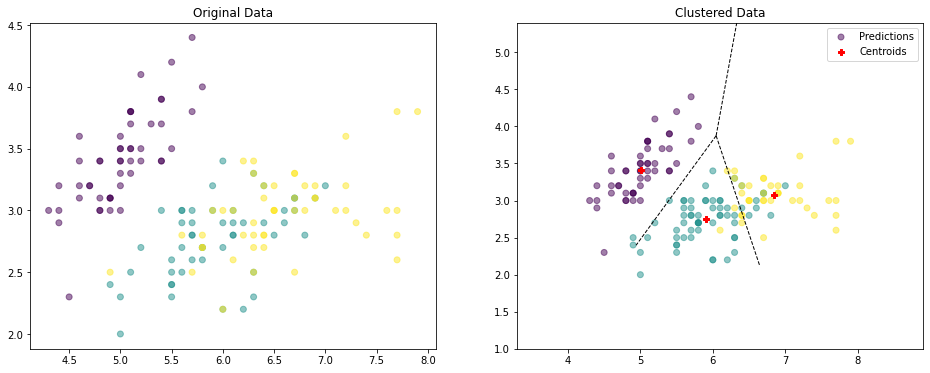

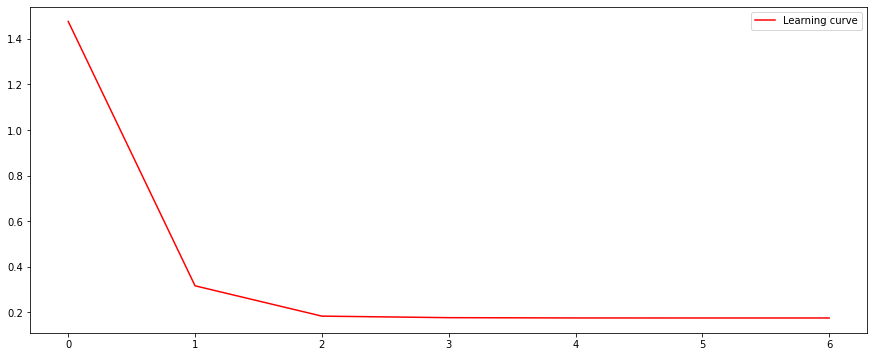

In [22]:
visual_CMeans(dataset3)

### 5, 6, 7, 8 - Experiments with  Graded Possibilistic C-Means

In [23]:
def multi_start_GPCM(x, g, c, tau=.0001, num_iter=10):
    # constants assignement
    precision = 4
    E = np.inf

    runs = num_iter  # number of re-starts
    clusters=c
    tau_val=tau
    
    t_before = time.time()
    
    for i in range(runs):
        km = GPCM(g, clusters, tau=tau_val)
        km.fit(x)
        EE= km.error
        Niter= km.iteration
        #print("run = {} - <E> = {:.{}f} ".format(i, EE, precision))
        print("run = {} - iterations = {} - <E> = {:.{}f} ".format(i, Niter-1, EE, precision))
        
        if EE < E:
            # store the best instance of trained model
            kmi = km
            E=EE
            best_run=i

    print ('\n best run = {}\n <E> = {:.{}f}'.format(best_run, E, precision))
    
    t_after = time.time()
    
    ## Compute training time
    t_training = t_after - t_before
    
    print(" Time for multi-start training (seconds): {:.{}f}\n runs = {}\n".format(t_training, precision, runs))

    return kmi, E, best_run

In [24]:
def visual_GPCM(dataset):

    x_labels = dataset.columns.values.tolist()
    x_labels.remove('target')
    y_label = 'target'

    x = np.array(dataset[x_labels].copy())
    y = np.array(dataset[y_label].copy())
    km, E, best_run = multi_start_GPCM(x, g=1, c=3, num_iter=10)
    c = km.get_centroids()[:, 0:2] # we plot the first two features, sepal length and sepal width
    U = km.get_U()
    hist = km.get_cost_history()
    p = km.predict(x)
    #print(U,p)
    plot_clustered_data(x,y,c,p)
    km.plot_cost_history(data=hist, label="Learning curve")
    
    return

run = 0 - iterations = 3 - <E> = 0.9010 
run = 1 - iterations = 4 - <E> = 0.8673 
run = 2 - iterations = 3 - <E> = 0.8475 
run = 3 - iterations = 3 - <E> = 0.9207 
run = 4 - iterations = 3 - <E> = 0.8329 
run = 5 - iterations = 5 - <E> = 0.7433 
run = 6 - iterations = 3 - <E> = 0.9233 
run = 7 - iterations = 5 - <E> = 0.7810 
run = 8 - iterations = 3 - <E> = 0.9137 
run = 9 - iterations = 4 - <E> = 0.8820 

 best run = 5
 <E> = 0.7433
 Time for multi-start training (seconds): 0.8329
 runs = 10



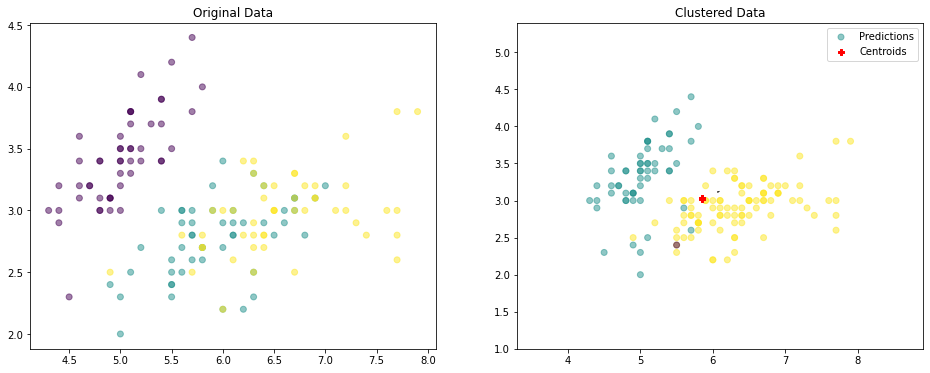

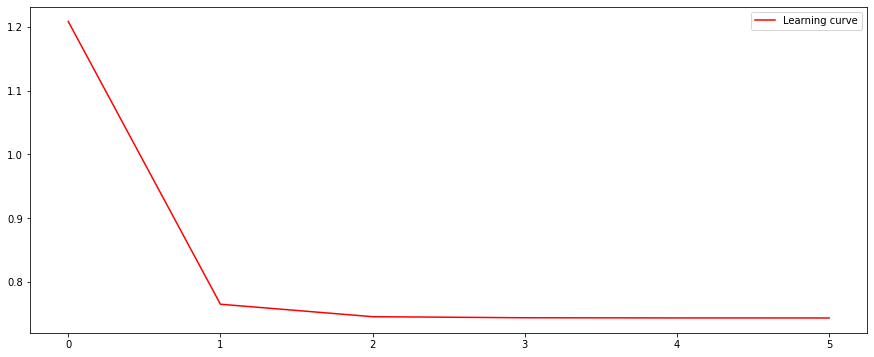

In [25]:
visual_GPCM(dataset3)

# Conclusion

we implemented three different clustering algorithms. We suggest the C_means since it's leads to the smallest error and computation time, followed by K-means with same error and longer time, and finally GPCM that lead to high error and the longest computation time.

# Optional Part A

## Clustering Ensembling

## Partition Diversity
We exploit **clustering algorithms diversity** to obtain ensemble models with high stability 

Possible strategies to increase diversity:
* Different clustering algorithms and weak clustering algos, e.g., only few iterations of k-means to avoid convergence;
* Randomizing using different initializations; different n. of clusters to look for;
* Different data sets: resampling with replacement (bagging); resampling without replacement;
* Different feature subsets (random subspace method).

## A1 - Consensus Matrix implementation

**A1**

A popular use of the Consensus Matrix:

* Given data set $Z ={z_1 , ..., z_N}$ with N elements.
* Pick the ensemble size L and the number of clusters $c$.
* Generate $L$ hard partitions of $Z$ in $c$ clusters.
* Form a co-association matrix for each partition,
$M(k)={m_{ij}(k)}$ of size $N\times N$, $k=1, ...,L$, where

$$m_{ij}(k) = \left \{ \begin{array}{rl}
1, &\mbox{ if $z_i$ and $z_j$ are in the same cluster in partition $k$},\\
0, &\mbox{ if $z_i$ and $z_j$ are in different clusters in partition $k$.}
\end{array}
\right.
$$
 
* Form a final co-association matrix M (consensus matrix) by averaging the $L$ co-association matrices M(k).
* Derive the final clustering using this matrix by applying an  $\alpha$-cut rule.

<img src="consensus-matrix.jpg" width="600"/>


In [26]:
def coassoc_matrix(U):
    #input: hard membership matrix
    #output: co-association matrix

    return C

def cons_matr(CC, alpha): 
      # input: CC list of L co-association matrices representing L partitions,
      # alpha threshold
      # output ensemble co-association matrix

    # insert code here
   
    # consensu matrix C as average the L co-association matrices in CC 
    # compare the elements of C with threshold alpha. 
                    #If larger set the element to 1 otherwise to 0
    # tranform C in an hard membership matrix 
    return C 

## A2, A3, A4 - Experiments on Consensus Matrix ensembling


* **A2**. For each data set, take the 9 hard best partitions obtained for data set DS2 in Part A and construct an ensemble using the tecnique of the consensus matrix. 
* **A3**. Visualize the results on the scatter plot, highlighting the centroids and using a different color for each cluster.
* **A4**. Measure the *accuracy* of the  partition induced by the consensus matrix by comparing it with the ground-truth constituted by the targets of the data sets. For the comparison use RAND index. Find the best value for the threshold $\alpha$.




In [27]:
#For each data set, take the 9 hard partitions obtained for data set DS2 in Part A

# insert code here

# using coassoc-matrix obtain the 9 co-association matrices

# insert code here

# using cons_matr (with alpha=.4) obtain the ensemble co-association matrix


# insert code here
   

# Create a scatterplot of first two features



# insert code here
   

# display learning curve



# insert code here
   


# Measure the accuracy of the hard partitions (GT is the ground-truth)

# insert code here



# Optional Part B: Study of the Graded Possibilistic C-Means algorithm

Implement a soft transition from probabilistic clustering to possibilistic clustering:
* Define a scheduling for $\beta$, e.g. $(1, .8, .6, .4, .2, 0)$ and for any value of $\beta$ run the GPCM starting from the results obtained in the previous run.
*  After each run evalutate the accuracy. 
* Test on the 3 data sets.

# (h) Discussion

* What are the best results?
* Additional discussion here